In [4]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchinfo import summary as torch_summary

import numpy as np
import matplotlib.pyplot as plt

In [6]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super().__init__()
        self.lambd = lambd
    
    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    """ResNet-18, 34에서 사용"""
    # channel 확장시킬떄 사용 expansion
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, option='B', use_shortcut = True):
        super().__init__()
        self.use_shortcut = use_shortcut

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # LLM과 함께 짠 코드 (채널수가 변경될 경우 shortcut연산이 안될 수 있음)
        self.shortcut = nn.Sequential()

        #크기가 같을때는 x와 동일, 크기가 다를때 크기/채널 조정하도록
        # stride 가 1이 아님 (공간 변화) or 채널수가 변하는 경우
        # useshortcut 옵션을 통해 shortcut을 사용하는 경우에만 해당 layer구성
        if use_shortcut and (stride != 1 or in_channels != out_channels * self.expansion):

            if option == 'A': 
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::stride, ::stride], # stride로 다운샘플링
                        (0, 0, 0, 0, 0, out_channels * self.expansion - in_channels),# 채널 zero-padding
                        "constant", 0
                    )
                )
            elif option == 'B':
                # Option B: Projection shortcut (차원 변경시만 1×1 conv)
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels * self.expansion,
                            kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels * self.expansion)
                )
             
    def forward(self,x):
      # x : torch.Size([1, 64, 32, 32])
        output = F.relu(self.bn1(self.conv1(x))) # torch.Size([1, 64, 30, 30]) -> padding 추가(short cut에서 더해주려면)
        # print(output.shape)
        output = self.bn2(self.conv2(output)) # torch.Size([1, 64, 28, 28])
        # print(output.shape)

        # skip connection (use_shortcut 옵션에 따라 달라지게끔)
        if self.use_shortcut:
            output +=self.shortcut(x) 
        # print(x.shape)

        output = F.relu(output)
        return output


class BottleneckBlock(nn.Module):
    """ResNet-50, 101, 152에서 사용"""
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1, option='B', use_shortcut=True):
        super().__init__()
        self.use_shortcut = use_shortcut
        # 1x1 conv
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3x3 conv
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 1x1 conv (expansion=4 / 4배 확장 64 -> 256, 128 -> 512, 256 -> 1024, 512 -> 2048)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.shortcut = nn.Sequential()
        
        # 위처럼 shorcut 사용하는 경우에만 해당 layer 구성
        if use_shortcut and (stride != 1 or in_channels != out_channels * self.expansion):
            if option == 'A':
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::stride, ::stride],
                        (0, 0, 0, 0, 0, out_channels * self.expansion - in_channels),
                        "constant", 0
                    )
                )
            elif option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels * self.expansion,
                            kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels * self.expansion)
                )
    
    def forward(self, x):
        # identity = self.shortcut(x)
        
        output = F.relu(self.bn1(self.conv1(x)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))

        # shorcut 적용 -> skip connection
        if self.use_shortcut:
            output += self.shortcut(x)
        
        output = F.relu(output)
        return output

In [7]:
class ResNet(nn.Module):
    # block -> Basic Block, num_blocks는 각 block개수 list형태로 [3,3,5,2]
    def __init__(self, block, num_blocks, in_channels=3, num_classes=10, option='B', use_shortcut=True):
        super().__init__()
        self.in_channels = 64
        self.option = option
        self.use_shortcut = use_shortcut

        # # 초기 conv (논문상의 ImageNet은 7x7로 conv, 3x3 max pool을 통해 downsampling 함)
        # # 그러나 우리 데이터 cifar 10은 32x32 이므로 최소화
        # self.conv1 = nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1)
        # self.bn1 = nn.BatchNorm2d(64)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 4개의 residual layers (64, 128, 256, 512)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1) # 
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []

        # 첫번째 block 쌓기 (stride 적용, 채널수도 변경 가능)
        # block 의 인자들 self,in_channels, out_channels,stride, option="B"
        layers.append(block(self.in_channels, out_channels, stride, option = self.option, use_shortcut = self.use_shortcut))
        self.in_channels = out_channels * block.expansion

        # 두번째 block부터는 무조건 stride=1, 채널수 동일하게 유지시키기
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, stride=1, option = self.option, use_shortcut = self.use_shortcut))

        return nn.Sequential(*layers)

    def forward(self,x):
        # 초기 convolution
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.maxpool(output)

        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        
        output = self.avgpool(output) 
        # print("avgpool", output.shape)
        # 적용후 tensor shape : [B, 512, 1, 1] -> flatten 필요 
        output = torch.flatten(output, 1)
        output = self.fc(output)
        # print(output.shape)

        # output = self.fc(self.avgpool(output))
        return output


    def summary(self, input_shape=(32, 32, 3)):
        """
        모델의 summary 출력
        
        Args:
            input_shape: 입력 shape (height, width, channels)
        """
        # PyTorch 형식으로 변환: (C, H, W)
        h, w, c = input_shape
        print(torch_summary(self, input_size=(1, c, h, w), 
                        col_names=["input_size", "output_size", "num_params"],
                        depth=3))



configuration = {
    'resnet34': {
        'block': BasicBlock,
        'num_blocks': [3, 4, 6, 3],
        'use_shortcut': True
    },
    'resnet34_plain': {
        'block': BasicBlock,
        'num_blocks': [3, 4, 6, 3],
        'use_shortcut': False
    },
    'resnet50': {
        'block': BottleneckBlock,
        'num_blocks': [3, 4, 6, 3],
        'use_shortcut': True
    },
    'resnet50_plain': {
        'block': BottleneckBlock,
        'num_blocks': [3, 4, 6, 3],
        'use_shortcut': False
    },
}

def build_resnet(input_shape, is_50=False, is_plain=False, num_classes=1000, option='B'):

    h, w, c = input_shape

    # 모델 타입 34
    if is_50:
        base_model = 'resnet50'
    else:
        base_model = 'resnet34'
    
    # plain 여부에 따라 최종 모델 타입 결정
    if is_plain:
        model_type = base_model + '_plain'
    else:
        model_type = base_model

    config = configuration[model_type]

    model = ResNet(
        block=config['block'],
        num_blocks=config['num_blocks'],
        in_channels=c,
        num_classes=num_classes,
        option=option,
        use_shortcut=config['use_shortcut']
    )

    return model



In [8]:
resnet_34 = build_resnet(input_shape=(224,224,3), is_50=False, is_plain=True)
resnet_34.summary()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [1, 3, 32, 32]            [1, 1000]                 --
├─Conv2d: 1-1                            [1, 3, 32, 32]            [1, 64, 16, 16]           9,472
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           [1, 64, 16, 16]           128
├─MaxPool2d: 1-3                         [1, 64, 16, 16]           [1, 64, 8, 8]             --
├─Sequential: 1-4                        [1, 64, 8, 8]             [1, 64, 8, 8]             --
│    └─BasicBlock: 2-1                   [1, 64, 8, 8]             [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             [1, 64, 8, 8]             128
│    │    └─Conv2d: 3-3                  [1, 64, 8, 8]             [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2

In [9]:
resnet_50 = build_resnet(input_shape=(224, 224,3), is_50=True,is_plain=False)
resnet_50.summary()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [1, 3, 32, 32]            [1, 1000]                 --
├─Conv2d: 1-1                            [1, 3, 32, 32]            [1, 64, 16, 16]           9,472
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           [1, 64, 16, 16]           128
├─MaxPool2d: 1-3                         [1, 64, 16, 16]           [1, 64, 8, 8]             --
├─Sequential: 1-4                        [1, 64, 8, 8]             [1, 256, 8, 8]            --
│    └─BottleneckBlock: 2-1              [1, 64, 8, 8]             [1, 256, 8, 8]            --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             [1, 64, 8, 8]             4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             [1, 64, 8, 8]             128
│    │    └─Conv2d: 3-3                  [1, 64, 8, 8]             [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d

Device: cuda
Number of classes: 37

===== Training ResNet34 =====


Epoch 1/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


[Epoch 1] Train Loss: 3.7216, Train Acc: 0.0608 | Val Loss: 6.7185, Val Acc: 0.0338


Epoch 2/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


[Epoch 2] Train Loss: 3.3116, Train Acc: 0.1057 | Val Loss: 4.8215, Val Acc: 0.0651


Epoch 3/100 [Val]: 100%|██████████| 15/15 [00:07<00:00,  1.95it/s]


[Epoch 3] Train Loss: 3.1961, Train Acc: 0.1258 | Val Loss: 4.0841, Val Acc: 0.0927


Epoch 4/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[Epoch 4] Train Loss: 3.0435, Train Acc: 0.1482 | Val Loss: 3.4515, Val Acc: 0.1033


Epoch 5/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


[Epoch 5] Train Loss: 2.8764, Train Acc: 0.1833 | Val Loss: 3.2209, Val Acc: 0.1442


Epoch 6/100 [Val]: 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


[Epoch 6] Train Loss: 2.7916, Train Acc: 0.1992 | Val Loss: 4.2399, Val Acc: 0.1033


Epoch 7/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


[Epoch 7] Train Loss: 2.6921, Train Acc: 0.2291 | Val Loss: 3.1928, Val Acc: 0.1436


Epoch 8/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


[Epoch 8] Train Loss: 2.5626, Train Acc: 0.2480 | Val Loss: 3.3430, Val Acc: 0.1494


Epoch 9/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[Epoch 9] Train Loss: 2.4103, Train Acc: 0.2913 | Val Loss: 3.3682, Val Acc: 0.1360


Epoch 10/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Epoch 10] Train Loss: 2.2871, Train Acc: 0.3309 | Val Loss: 3.3708, Val Acc: 0.1475


Epoch 11/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Epoch 11] Train Loss: 2.2117, Train Acc: 0.3432 | Val Loss: 3.1008, Val Acc: 0.2061


Epoch 12/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Epoch 12] Train Loss: 2.1140, Train Acc: 0.3711 | Val Loss: 2.9123, Val Acc: 0.2251


Epoch 13/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Epoch 13] Train Loss: 1.9591, Train Acc: 0.4093 | Val Loss: 3.0478, Val Acc: 0.2161


Epoch 14/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


[Epoch 14] Train Loss: 1.8879, Train Acc: 0.4314 | Val Loss: 3.2397, Val Acc: 0.2009


Epoch 15/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


[Epoch 15] Train Loss: 1.7125, Train Acc: 0.4721 | Val Loss: 2.8726, Val Acc: 0.2687


Epoch 16/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


[Epoch 16] Train Loss: 1.6168, Train Acc: 0.5028 | Val Loss: 3.4035, Val Acc: 0.2303


Epoch 17/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


[Epoch 17] Train Loss: 1.5448, Train Acc: 0.5237 | Val Loss: 2.8336, Val Acc: 0.2657


Epoch 18/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Epoch 18] Train Loss: 1.3589, Train Acc: 0.5831 | Val Loss: 2.9626, Val Acc: 0.2478


Epoch 19/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


[Epoch 19] Train Loss: 1.2044, Train Acc: 0.6158 | Val Loss: 3.0532, Val Acc: 0.2845


Epoch 20/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Epoch 20] Train Loss: 1.0939, Train Acc: 0.6602 | Val Loss: 3.0583, Val Acc: 0.2587


Epoch 21/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Epoch 21] Train Loss: 0.9918, Train Acc: 0.6769 | Val Loss: 3.1256, Val Acc: 0.2589


Epoch 22/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


[Epoch 22] Train Loss: 0.8497, Train Acc: 0.7369 | Val Loss: 3.1179, Val Acc: 0.2753


Epoch 23/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


[Epoch 23] Train Loss: 0.7328, Train Acc: 0.7832 | Val Loss: 3.5738, Val Acc: 0.2706


Epoch 24/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Epoch 24] Train Loss: 0.6276, Train Acc: 0.8055 | Val Loss: 3.0398, Val Acc: 0.3162


Epoch 25/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Epoch 25] Train Loss: 0.4883, Train Acc: 0.8513 | Val Loss: 3.2228, Val Acc: 0.2916


Epoch 26/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


[Epoch 26] Train Loss: 0.3891, Train Acc: 0.8901 | Val Loss: 3.2286, Val Acc: 0.3241


Epoch 27/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


[Epoch 27] Train Loss: 0.3181, Train Acc: 0.9169 | Val Loss: 3.1830, Val Acc: 0.3325
⏹ Early stopping triggered at epoch 27

===== Training ResNet34-Plain =====


Epoch 1/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Epoch 1] Train Loss: 3.6634, Train Acc: 0.0246 | Val Loss: 3.6145, Val Acc: 0.0273


Epoch 2/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Epoch 2] Train Loss: 3.5718, Train Acc: 0.0349 | Val Loss: 5.8896, Val Acc: 0.0422


Epoch 3/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


[Epoch 3] Train Loss: 3.4981, Train Acc: 0.0558 | Val Loss: 8.9068, Val Acc: 0.0422


Epoch 4/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


[Epoch 4] Train Loss: 3.4560, Train Acc: 0.0592 | Val Loss: 4.3510, Val Acc: 0.0463


Epoch 5/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Epoch 5] Train Loss: 3.3923, Train Acc: 0.0723 | Val Loss: 4.6204, Val Acc: 0.0493


Epoch 6/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


[Epoch 6] Train Loss: 3.3143, Train Acc: 0.0840 | Val Loss: 3.9686, Val Acc: 0.0422


Epoch 7/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


[Epoch 7] Train Loss: 3.3212, Train Acc: 0.0831 | Val Loss: 18.4179, Val Acc: 0.0349


Epoch 8/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


[Epoch 8] Train Loss: 3.2785, Train Acc: 0.0778 | Val Loss: 3.8818, Val Acc: 0.0444


Epoch 9/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


[Epoch 9] Train Loss: 3.2520, Train Acc: 0.0974 | Val Loss: 3.6906, Val Acc: 0.0591


Epoch 10/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Epoch 10] Train Loss: 3.2093, Train Acc: 0.0968 | Val Loss: 3.8277, Val Acc: 0.0758


Epoch 11/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Epoch 11] Train Loss: 3.1883, Train Acc: 0.0946 | Val Loss: 4.4908, Val Acc: 0.0594
⏹ Early stopping triggered at epoch 11

===== Training ResNet50 =====


Epoch 1/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Epoch 1] Train Loss: 4.1002, Train Acc: 0.0405 | Val Loss: 3.6538, Val Acc: 0.0373


Epoch 2/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


[Epoch 2] Train Loss: 3.5359, Train Acc: 0.0628 | Val Loss: 6.7236, Val Acc: 0.0493


Epoch 3/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


[Epoch 3] Train Loss: 3.3915, Train Acc: 0.0904 | Val Loss: 3.8906, Val Acc: 0.0932


Epoch 4/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


[Epoch 4] Train Loss: 3.2565, Train Acc: 0.1150 | Val Loss: 3.4649, Val Acc: 0.0927


Epoch 5/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


[Epoch 5] Train Loss: 3.1714, Train Acc: 0.1328 | Val Loss: 3.8859, Val Acc: 0.0780


Epoch 6/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


[Epoch 6] Train Loss: 3.0673, Train Acc: 0.1677 | Val Loss: 4.3104, Val Acc: 0.1047


Epoch 7/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


[Epoch 7] Train Loss: 2.9275, Train Acc: 0.1886 | Val Loss: 3.5441, Val Acc: 0.1197


Epoch 8/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


[Epoch 8] Train Loss: 2.7935, Train Acc: 0.2140 | Val Loss: 3.7398, Val Acc: 0.1063


Epoch 9/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


[Epoch 9] Train Loss: 2.7116, Train Acc: 0.2369 | Val Loss: 3.1568, Val Acc: 0.1526


Epoch 10/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[Epoch 10] Train Loss: 2.6550, Train Acc: 0.2508 | Val Loss: 3.1581, Val Acc: 0.1698


Epoch 11/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Epoch 11] Train Loss: 2.5208, Train Acc: 0.2754 | Val Loss: 3.5261, Val Acc: 0.1379


Epoch 12/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Epoch 12] Train Loss: 2.4416, Train Acc: 0.3002 | Val Loss: 3.0957, Val Acc: 0.1878


Epoch 13/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[Epoch 13] Train Loss: 2.5045, Train Acc: 0.2902 | Val Loss: 39.3331, Val Acc: 0.0651


Epoch 14/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


[Epoch 14] Train Loss: 2.4648, Train Acc: 0.2974 | Val Loss: 4.0377, Val Acc: 0.1240


Epoch 15/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Epoch 15] Train Loss: 2.2066, Train Acc: 0.3524 | Val Loss: 3.5098, Val Acc: 0.2096


Epoch 16/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


[Epoch 16] Train Loss: 2.0971, Train Acc: 0.3859 | Val Loss: 2.7588, Val Acc: 0.2597


Epoch 17/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


[Epoch 17] Train Loss: 1.8886, Train Acc: 0.4355 | Val Loss: 3.1759, Val Acc: 0.2153


Epoch 18/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


[Epoch 18] Train Loss: 1.7923, Train Acc: 0.4646 | Val Loss: 3.0845, Val Acc: 0.2235


Epoch 19/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Epoch 19] Train Loss: 1.6831, Train Acc: 0.4908 | Val Loss: 3.6589, Val Acc: 0.1992


Epoch 20/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


[Epoch 20] Train Loss: 1.5661, Train Acc: 0.5128 | Val Loss: 2.9223, Val Acc: 0.2756


Epoch 21/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


[Epoch 21] Train Loss: 1.4383, Train Acc: 0.5513 | Val Loss: 3.4796, Val Acc: 0.2213


Epoch 22/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


[Epoch 22] Train Loss: 1.3392, Train Acc: 0.5859 | Val Loss: 3.6951, Val Acc: 0.2025


Epoch 23/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


[Epoch 23] Train Loss: 1.1586, Train Acc: 0.6342 | Val Loss: 3.5180, Val Acc: 0.2679


Epoch 24/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


[Epoch 24] Train Loss: 1.0035, Train Acc: 0.6730 | Val Loss: 3.7827, Val Acc: 0.2758


Epoch 25/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


[Epoch 25] Train Loss: 0.8680, Train Acc: 0.7254 | Val Loss: 3.9488, Val Acc: 0.2437


Epoch 26/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


[Epoch 26] Train Loss: 0.7886, Train Acc: 0.7492 | Val Loss: 3.9250, Val Acc: 0.2537
⏹ Early stopping triggered at epoch 26

===== Training ResNet50-Plain =====


Epoch 1/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


[Epoch 1] Train Loss: 3.7219, Train Acc: 0.0301 | Val Loss: 3.6094, Val Acc: 0.0273


Epoch 2/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Epoch 2] Train Loss: 3.6466, Train Acc: 0.0251 | Val Loss: 3.6152, Val Acc: 0.0270


Epoch 3/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Epoch 3] Train Loss: 3.5874, Train Acc: 0.0463 | Val Loss: 3.6076, Val Acc: 0.0338


Epoch 4/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


[Epoch 4] Train Loss: 3.5557, Train Acc: 0.0405 | Val Loss: 3.7027, Val Acc: 0.0409


Epoch 5/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Epoch 5] Train Loss: 3.5171, Train Acc: 0.0460 | Val Loss: 3.8166, Val Acc: 0.0488


Epoch 6/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Epoch 6] Train Loss: 3.4751, Train Acc: 0.0527 | Val Loss: 6.7573, Val Acc: 0.0480


Epoch 7/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


[Epoch 7] Train Loss: 3.4410, Train Acc: 0.0592 | Val Loss: 3.8405, Val Acc: 0.0540


Epoch 8/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


[Epoch 8] Train Loss: 3.4124, Train Acc: 0.0645 | Val Loss: 3.5446, Val Acc: 0.0512


Epoch 9/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


[Epoch 9] Train Loss: 3.3853, Train Acc: 0.0686 | Val Loss: 3.4312, Val Acc: 0.0662


Epoch 10/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


[Epoch 10] Train Loss: 3.3500, Train Acc: 0.0672 | Val Loss: 4.2813, Val Acc: 0.0548


Epoch 11/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Epoch 11] Train Loss: 3.3414, Train Acc: 0.0737 | Val Loss: 3.6103, Val Acc: 0.0780


Epoch 12/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


[Epoch 12] Train Loss: 3.3093, Train Acc: 0.0873 | Val Loss: 3.3952, Val Acc: 0.0771


Epoch 13/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


[Epoch 13] Train Loss: 3.3286, Train Acc: 0.0787 | Val Loss: 5.0355, Val Acc: 0.0469


Epoch 14/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


[Epoch 14] Train Loss: 3.3113, Train Acc: 0.0818 | Val Loss: 3.5533, Val Acc: 0.0711


Epoch 15/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[Epoch 15] Train Loss: 3.2484, Train Acc: 0.0898 | Val Loss: 3.5192, Val Acc: 0.0646


Epoch 16/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


[Epoch 16] Train Loss: 3.2267, Train Acc: 0.0926 | Val Loss: 3.5777, Val Acc: 0.0771


Epoch 17/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


[Epoch 17] Train Loss: 3.2178, Train Acc: 0.0940 | Val Loss: 3.6273, Val Acc: 0.0698


Epoch 18/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


[Epoch 18] Train Loss: 3.1805, Train Acc: 0.1099 | Val Loss: 3.3988, Val Acc: 0.0929


Epoch 19/100 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


[Epoch 19] Train Loss: 3.1526, Train Acc: 0.1038 | Val Loss: 3.6094, Val Acc: 0.0886


Epoch 20/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


[Epoch 20] Train Loss: 3.1023, Train Acc: 0.1189 | Val Loss: 3.3332, Val Acc: 0.0919


Epoch 21/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Epoch 21] Train Loss: 3.0466, Train Acc: 0.1286 | Val Loss: 3.5738, Val Acc: 0.0684


Epoch 22/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


[Epoch 22] Train Loss: 3.0530, Train Acc: 0.1267 | Val Loss: 3.8319, Val Acc: 0.0932


Epoch 23/100 [Val]: 100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


[Epoch 23] Train Loss: 3.0538, Train Acc: 0.1203 | Val Loss: 3.5393, Val Acc: 0.1003


Epoch 24/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


[Epoch 24] Train Loss: 3.0114, Train Acc: 0.1314 | Val Loss: 3.5551, Val Acc: 0.0853


Epoch 25/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


[Epoch 25] Train Loss: 2.9437, Train Acc: 0.1473 | Val Loss: 3.6751, Val Acc: 0.0946


Epoch 26/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


[Epoch 26] Train Loss: 2.9240, Train Acc: 0.1443 | Val Loss: 3.8563, Val Acc: 0.0801


Epoch 27/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


[Epoch 27] Train Loss: 2.8988, Train Acc: 0.1562 | Val Loss: 3.5065, Val Acc: 0.0916


Epoch 28/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


[Epoch 28] Train Loss: 2.8679, Train Acc: 0.1702 | Val Loss: 4.8819, Val Acc: 0.0780


Epoch 29/100 [Val]: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


[Epoch 29] Train Loss: 2.8332, Train Acc: 0.1777 | Val Loss: 3.6541, Val Acc: 0.1008


Epoch 30/100 [Val]: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


[Epoch 30] Train Loss: 2.8070, Train Acc: 0.1708 | Val Loss: 3.4646, Val Acc: 0.1161
⏹ Early stopping triggered at epoch 30


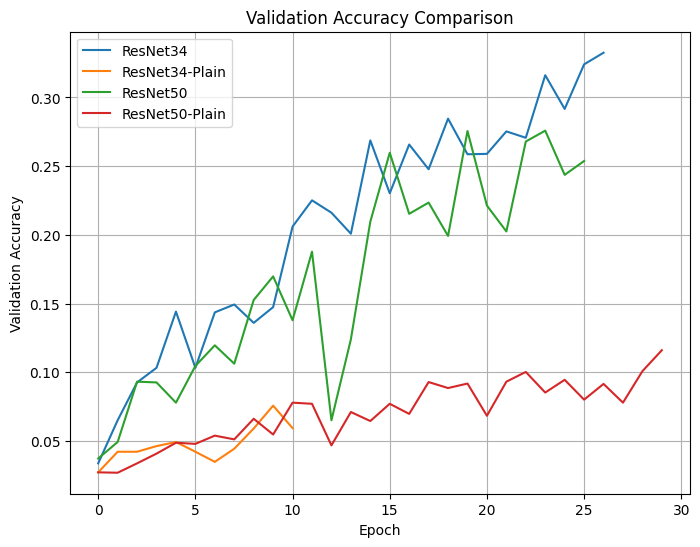

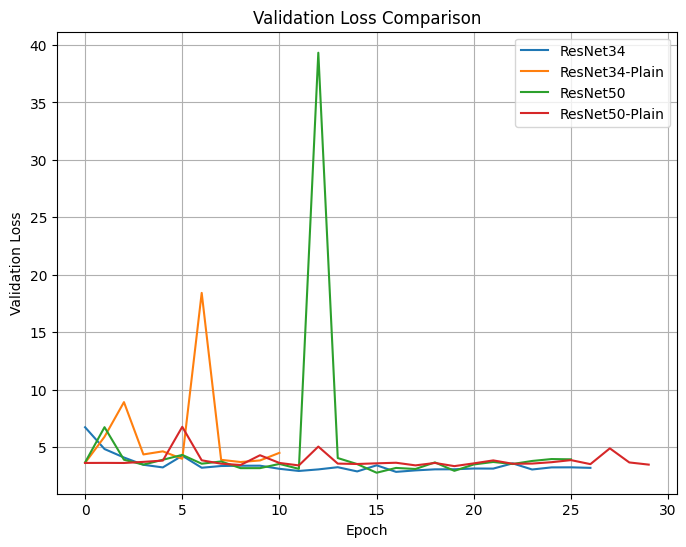

In [25]:
# ===============================
# 0. Imports
# ===============================
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===============================
# 1. Reproducibility (Seed)
# ===============================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ===============================
# 2. Hyperparameters
# ===============================
BATCH_SIZE = 256
EPOCHS = 100          # 최대 epoch
NUM_WORKERS = 4
LR = 1e-3
PATIENCE = 5         # early stopping patience

# ===============================
# 3. Dataset & Dataloader
# ===============================
transform_224 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

data_path = "./data"

train_ds = datasets.OxfordIIITPet(
    root=data_path,
    split="trainval",
    target_types="category",
    transform=transform_224,
    download=True
)

test_ds = datasets.OxfordIIITPet(
    root=data_path,
    split="test",
    target_types="category",
    transform=transform_224,
    download=True
)

NUM_CLASSES = len(train_ds.classes)
print("Number of classes:", NUM_CLASSES)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# ===============================
# 4. Early Stopping
# ===============================
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ===============================
# 5. Training & Validation Loop
# ===============================
def train_model(
    model,
    trainloader,
    valloader,
    epochs,
    device,
    lr=1e-3,
    patience=10
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    early_stopping = EarlyStopping(patience=patience)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    model.to(device)

    for epoch in range(epochs):
        # ----- Train -----
        model.train()
        train_loss, correct, total = 0, 0, 0

        for x, y in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(y).sum().item()
            total += y.size(0)

        train_loss /= len(trainloader)
        train_acc = correct / total

        # ----- Validation -----
        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for x, y in tqdm(valloader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)

                val_loss += loss.item()
                _, preds = outputs.max(1)
                correct += preds.eq(y).sum().item()
                total += y.size(0)

        val_loss /= len(valloader)
        val_acc = correct / total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"[Epoch {epoch+1}] "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        # ----- Early Stopping -----
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"⏹ Early stopping triggered at epoch {epoch+1}")
            break

    return history

# ===============================
# 6. Build & Run Models
# ===============================
histories = {}

models_to_run = {
    "ResNet34": build_resnet((224, 224, 3), is_50=False, is_plain=False, num_classes=NUM_CLASSES),
    "ResNet34-Plain": build_resnet((224, 224, 3), is_50=False, is_plain=True, num_classes=NUM_CLASSES),
    "ResNet50": build_resnet((224, 224, 3), is_50=True, is_plain=False, num_classes=NUM_CLASSES),
    "ResNet50-Plain": build_resnet((224, 224, 3), is_50=True, is_plain=True, num_classes=NUM_CLASSES),
}

for name, model in models_to_run.items():
    print(f"\n===== Training {name} =====")
    histories[name] = train_model(
        model,
        train_loader,
        test_loader,   # test를 validation으로 사용
        epochs=EPOCHS,
        device=device,
        lr=LR,
        patience=PATIENCE
    )

# ===============================
# 7. Visualization
# ===============================
plt.figure(figsize=(8, 6))
for name, history in histories.items():
    plt.plot(history["val_acc"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for name, history in histories.items():
    plt.plot(history["val_loss"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
histories['ResNet34'].keys()
histories.keys()

dict_keys(['ResNet34', 'ResNet34-Plain', 'ResNet50', 'ResNet50-Plain'])

Validation Acc를 비교해본 결과 ResNet34 에서의 결과가 가장 좋았던것을 확인할 수 있었습니다

In [33]:
print("ResNet34 validation accuracy :" , max(histories['ResNet34']['val_acc']))
print("ResNet34-Plain validation accuracy :" , max(histories['ResNet34-Plain']['val_acc']))
print("ResNet50 validation accuracy :" , max(histories['ResNet50']['val_acc']))
print("ResNet50-Plain validation accuracy :" , max(histories['ResNet50-Plain']['val_acc']))

ResNet34 validation accuracy : 0.33251567184518943
ResNet34-Plain validation accuracy : 0.07576996456800218
ResNet50 validation accuracy : 0.27582447533387844
ResNet50-Plain validation accuracy : 0.116107931316435
